# Model-Based Decision Making

This notebook contains the final code of Group 22's assignment for the course EPA1361.

In this code, we explore scenarios for the studied policy problem (flood risk management for the IJssel river) using open exploration, and then apply directed search (MORDM) to find optimal results.

## Table of contents
1. [Exploration](#Exploration)
    1. [Problem formulation 3](#Problem-formulation-3)
    2. [Problem formulation 4](#Problem-formulation-4)
2. [Optimization](#Optimization)
    1. [Convergence](#Convergence)
    2. [Constraints and solutions](#Constraints-and-solutions)
    3. [Uncertainty](#Uncertainty)
    4. [Scenario discovery using PRIM](#Scenario-discovery-using-PRIM)
    5. [Sensitivity analysis using extra trees](#Sensitivity-analysis-using-extra-trees)
    6. [Robustness](#Robustness)

_The items in this table of contents may only be clickable in the browser version of Jupyter Notebook._

In [1]:
# Settings
save_exploration_data = False
save_figures = True
save_hv_data = False

In [2]:
# All needed imports
## Standard packages
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from pathlib import Path
import shutil
from datetime import datetime
import json
import numpy as np
import collections
## EMA workbench!
from ema_workbench import (
    Model,
    Policy,
    Scenario,
    MultiprocessingEvaluator,
    HypervolumeMetric,
    ScalarOutcome,
    ema_logging,
    save_results
)
## EMA workbench - optimization
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
## EMA workbench - analysis
from ema_workbench.analysis import (
    parcoords,
    prim,
    dimensional_stacking,
    feature_scoring,
    scenario_discovery_util
)
## IJssel dike model
from problem_formulation import get_model_for_problem_formulation

In [3]:
# Set up
## Set up logging
ema_logging.log_to_stderr(ema_logging.INFO)
## Set up folders
if save_exploration_data:
    exploration_data_path = "./MBDM_Final_Data/Exploration_Data"
    Path(exploration_data_path).mkdir(parents=True, exist_ok=True)
if save_figures:
    figures_path = "./MBDM_Final_Data/Figures"
    Path(figures_path).mkdir(parents=True, exist_ok=True)

## Exploration

We will explore five policies:

1. a baseline (no actions taken)
2. implementing room for the river (RfR) everywhere
3. heightening all dikes by 50cm in every timestep
4. RfR only near Natura 2000 areas (dike rings 1 and 2), dike heightening of 50 cm in timestep 3 in the other dike rings
5. the final policy of the MBDM debate, including RfR in dike rings 1 and 4, and moderate dike heightening in each dike ring

In [4]:
# In the two problem formulations we want to explore, the levers are the same.
# This function will return the policy list, based on the default values of a problem formulation.

def get_policies(do_nothing_dict):
    return [
        Policy("Baseline", **do_nothing_dict),
        Policy("RfR everywhere",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0':1,
                    '0_RfR 1':1,
                    '0_RfR 2':1,
                    '1_RfR 0':1,
                    '1_RfR 1':1,
                    '1_RfR 2':1,
                    '2_RfR 0':1,
                    '2_RfR 1':1,
                    '2_RfR 2':1,
                    '3_RfR 0':1,
                    '3_RfR 1':1,
                    '3_RfR 2':1,
                    '4_RfR 0':1,
                    '4_RfR 1':1,
                    '4_RfR 2':1
                }
            )
        ),
        Policy("Dike heightening everywhere",
            **dict(
                do_nothing_dict,
                **{'A.1_DikeIncrease 0':5,
                    'A.1_DikeIncrease 1':5,
                    'A.1_DikeIncrease 2':5,
                    'A.2_DikeIncrease 0':5,
                    'A.2_DikeIncrease 1':5,
                    'A.2_DikeIncrease 2':5,
                    'A.3_DikeIncrease 0':5,
                    'A.3_DikeIncrease 1':5,
                    'A.3_DikeIncrease 2':5,
                    'A.4_DikeIncrease 0':5,
                    'A.4_DikeIncrease 1':5,
                    'A.4_DikeIncrease 2':5,
                    'A.5_DikeIncrease 0':5,
                    'A.5_DikeIncrease 1':5,
                    'A.5_DikeIncrease 2':5
                }
            )
        ),
        # Dike heightening occurs only in the last timesteps.
        Policy("RfR in Natura 2000 areas",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0':1,
                   '1_RfR 0':1,
                   'A.3_DikeIncrease 0': 0,
                   'A.3_DikeIncrease 1': 0,
                   'A.3_DikeIncrease 2': 5,
                   'A.4_DikeIncrease 0': 0,
                   'A.4_DikeIncrease 1': 0,
                   'A.4_DikeIncrease 2': 5,
                   'A.5_DikeIncrease 0': 0,
                   'A.5_DikeIncrease 1': 0,
                   'A.5_DikeIncrease 2': 5
                }
            )
        ),
        # Policy agreed upon by majority of actors during the debate
        Policy("Final approved policy",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0': 1,
                   'A.1_DikeIncrease 1': 3,
                   'A.2_DikeIncrease 0': 3,
                   'A.3_DikeIncrease 0': 10,
                   '3_RfR 0': 1,
                   'A.4_DikeIncrease 1': 3,
                   'A.5_DikeIncrease 0': 10
                }
            )
        ),
    ]

# The code for the two studied problem formulations could also be simplfied into a loop, but it is convenient to keep them separate if steps or parameters need to be changed for one of the two.

### Problem formulation 3

In [5]:
## Get the model
dike_model, planning_steps = get_model_for_problem_formulation(2)

## Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

In [6]:
## Define policies to explore
policies = get_policies(get_do_nothing_dict())

In [7]:
# Run the model with the EMA workbench
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 200 scenarios * 5 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.17it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
# Save exploration results if needed
if save_exploration_data:
    save_results(results, exploration_data_path + '/exploration_PF3_results.tar.gz')

In [9]:
# Separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']

In [10]:
# Convert outcomes into a dataframe to plot
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

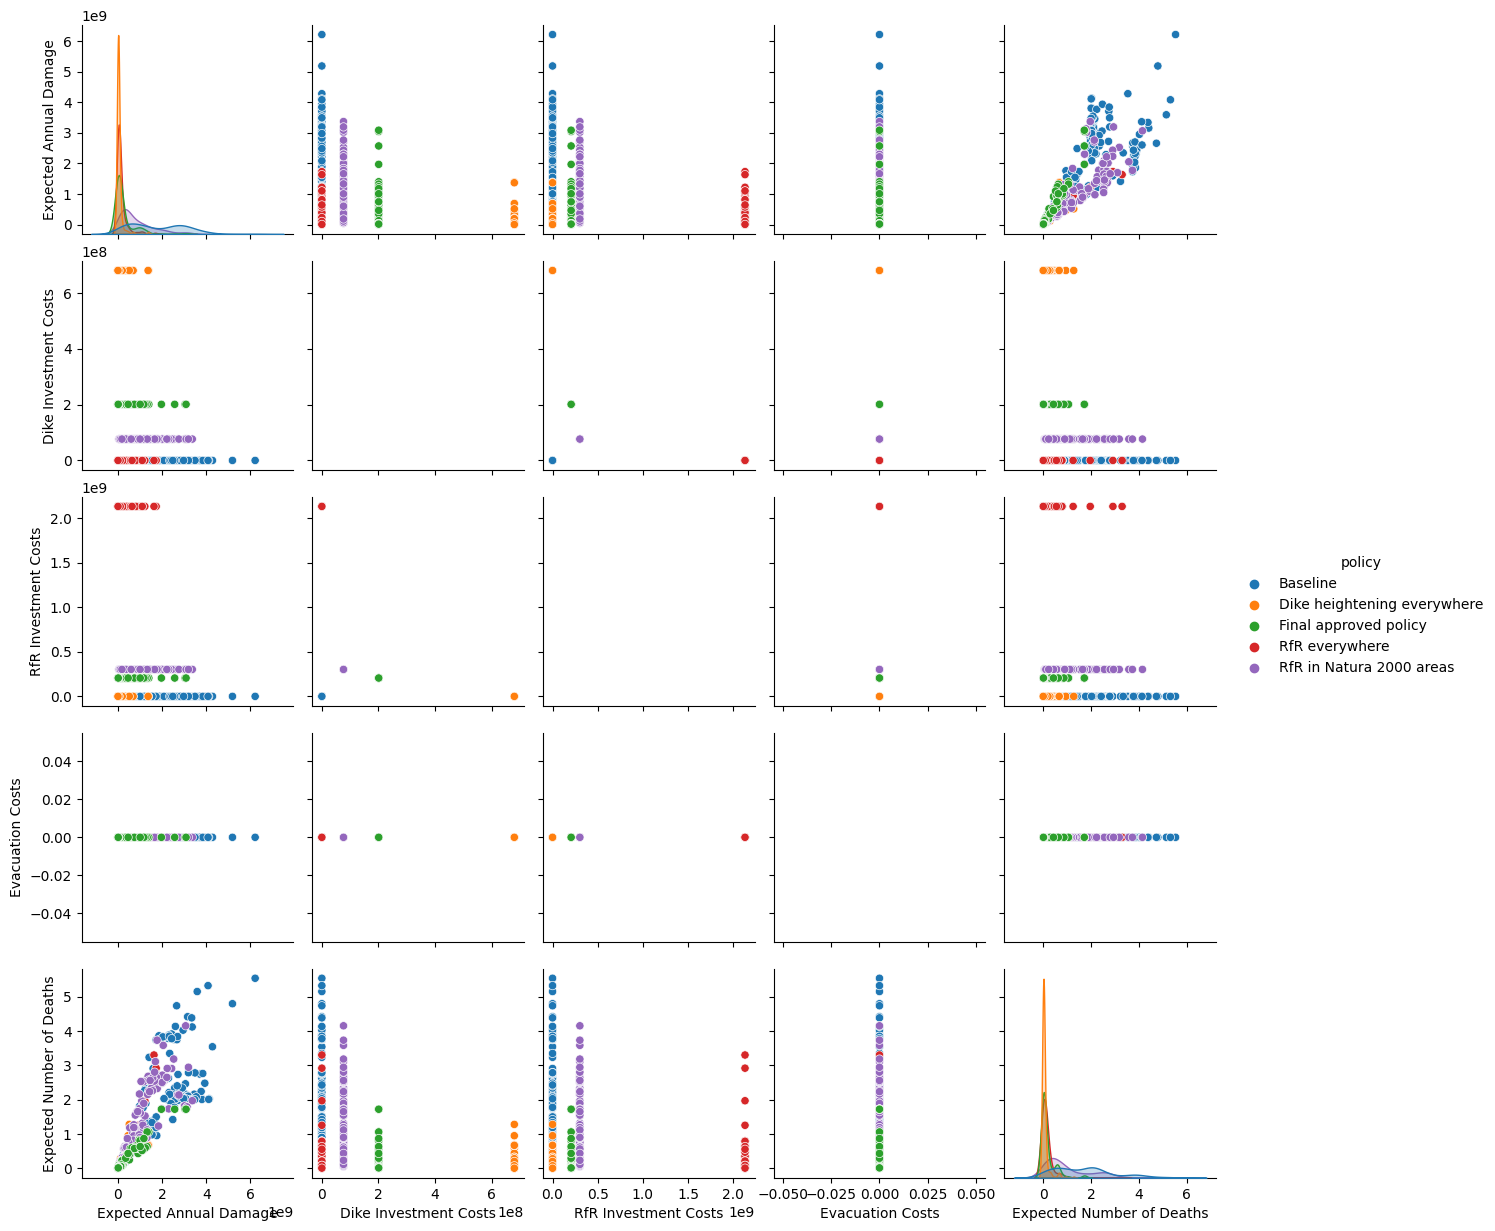

In [11]:
# Plot results
sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
if save_figures:
    plt.savefig(figures_path + "/exploration_PF3_policies.png", dpi=300)
plt.show()

### Problem formulation 4

In [13]:
## Get the model
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

In [14]:
## Define policies to explore
policies = get_policies(get_do_nothing_dict())

In [15]:
# Run the model with the EMA workbench
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 200 scenarios * 5 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
# Save exploration results if needed
if save_exploration_data:
    save_results(results, exploration_data_path + '/exploration_PF4_results.tar.gz')

In [17]:
# Separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']

In [18]:
# Convert outcomes into a dataframe to plot
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

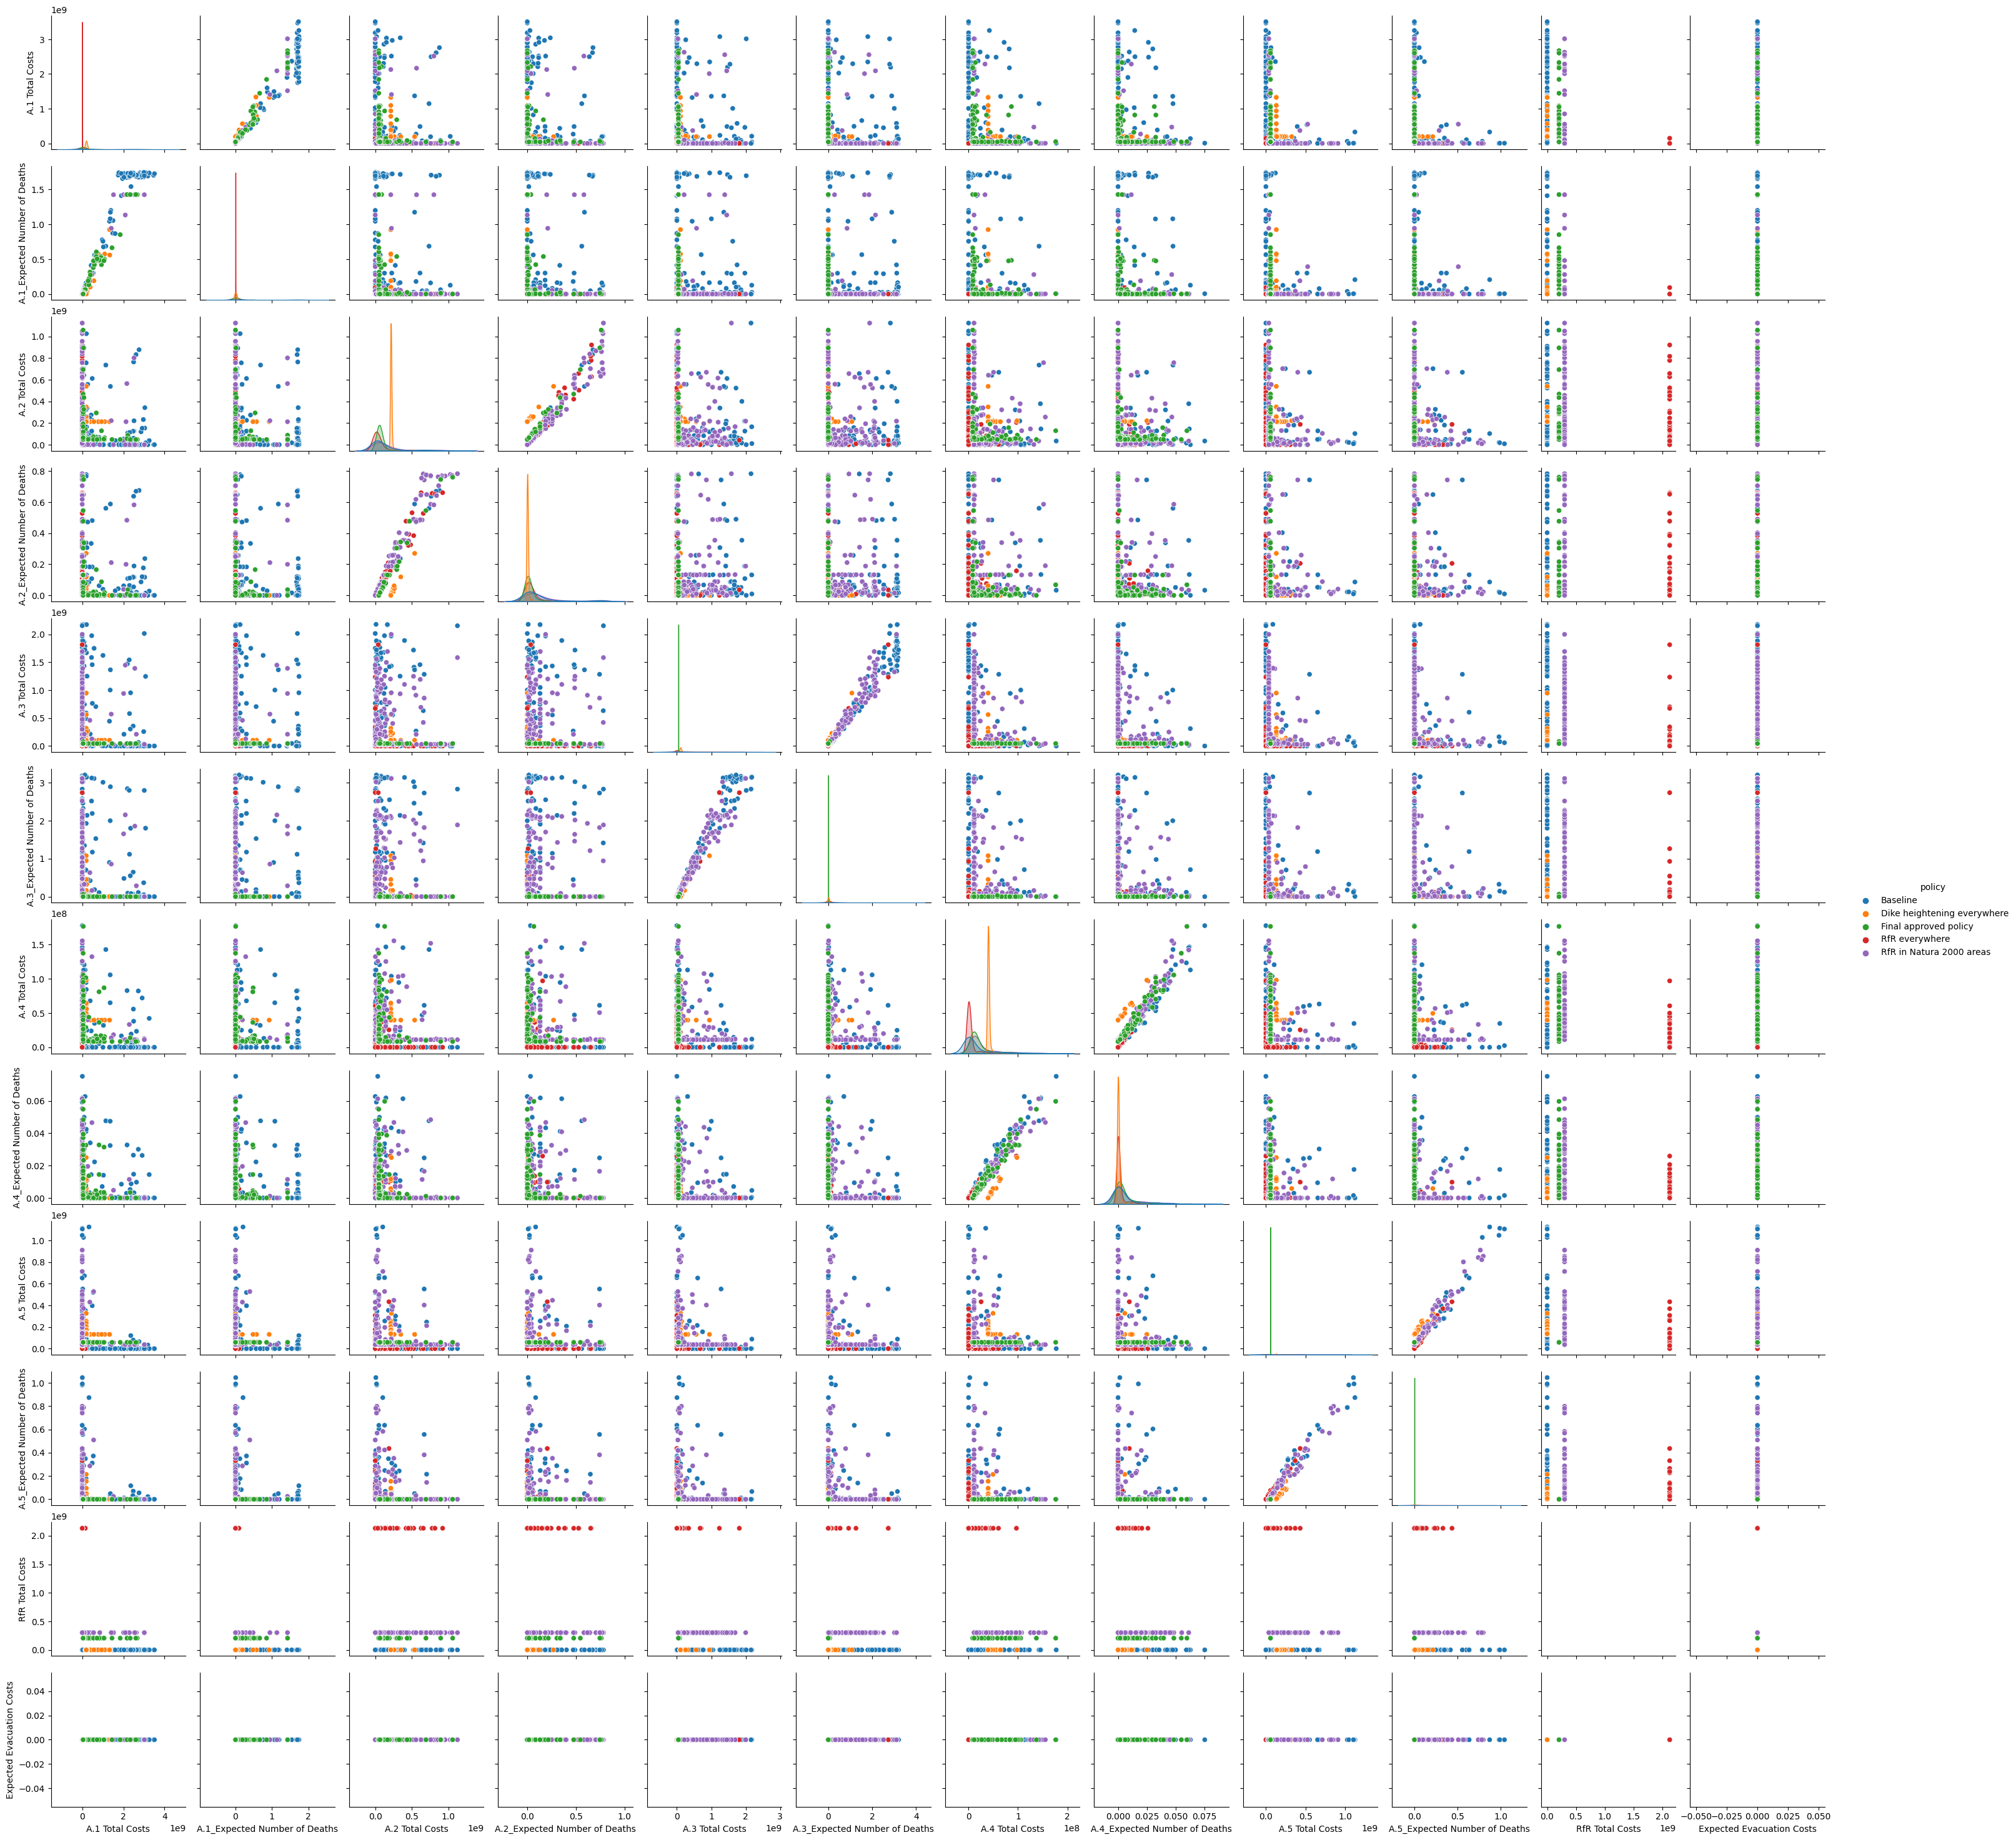

In [19]:
# Plot results
sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
if save_figures:
    plt.savefig(figures_path + "/exploration_PF4_policies.png", dpi=300)
plt.show()

## Optimization

In [21]:
# Optimization settings
convergence_metrics = [EpsilonProgress()]
nfe = 1000
epsilon = [0.5,0.5,0.5,0.01,0.01]

_Each epsilon value corresponds to a model outcome.
The model outcomes are: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties.
We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties._

In [22]:
# Get the model
dike_model, planning_steps = get_model_for_problem_formulation(2)

# The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate 0': 1.5,
    'discount rate 1': 1.5,
    'discount rate 2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

# Set up data folder and remove "tmp" folder if left from previous runs
optimization_data_path = "./MBDM_Final_Data/Optimization_Data"
Path(optimization_data_path).mkdir(parents=True, exist_ok=True)
tmppath = Path(optimization_data_path) / 'tmp'
if tmppath.exists() and tmppath.is_dir():
    shutil.rmtree(tmppath)

In [23]:
# Set convergence metrics
mordm_data_filename = "MORDM_HV_1.tar.gz"
convergence_metrics = [
    # Save data as archive, for hypervolume
    ArchiveLogger(
        optimization_data_path,
        [l.name for l in dike_model.levers],
        [o.name for o in dike_model.outcomes],
        base_filename=mordm_data_filename,
    ),
    # Track epsilon progress
    EpsilonProgress(),
]

In [24]:
# Run optimization
with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, convergence=convergence_metrics,reference=reference_scenario)

optimization_result

[MainProcess/INFO] pool started with 10 workers
1098it [00:19, 56.40it/s]                                                      
[MainProcess/INFO] optimization completed, found 44 solutions
[MainProcess/INFO] terminating pool


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,1,0,0,0,0,1,0,0,0,...,1,3,7,4,6,0.000000e+00,6.004939e+08,1.153000e+08,0.000000,0.000000
1,0,0,1,0,0,0,1,1,0,0,...,3,7,4,4,2,7.384638e+06,5.058528e+08,1.460000e+08,120.575700,0.003540
2,1,0,0,0,0,1,1,1,1,0,...,3,6,3,0,2,3.444905e+07,2.834406e+08,1.027900e+09,692.838117,0.008413
3,0,0,0,0,0,0,1,1,1,0,...,2,1,7,4,6,0.000000e+00,4.571969e+08,2.133000e+08,0.000000,0.000000
4,1,0,0,0,0,0,1,1,0,1,...,8,4,3,2,3,0.000000e+00,3.843222e+08,3.884000e+08,0.000000,0.000000
5,0,1,0,0,0,0,1,0,0,0,...,7,9,3,3,6,1.782488e+08,3.363667e+08,1.153000e+08,5845.860243,0.021324
6,1,0,0,0,0,0,1,0,1,0,...,7,7,3,0,5,5.772739e+07,3.712890e+08,1.460000e+08,2380.545019,0.005765
7,0,0,0,0,0,0,0,0,0,0,...,4,7,4,3,6,7.664320e+06,5.633155e+08,0.000000e+00,201.398495,0.001577
8,0,0,0,0,1,1,1,1,0,1,...,1,1,3,3,1,7.384883e+07,2.211444e+08,1.251600e+09,2470.910817,0.007479
9,0,0,0,0,1,1,1,1,0,1,...,9,3,0,6,5,5.730658e+07,2.762956e+08,6.182000e+08,2219.511716,0.005775


### Convergence

Hypervolume is very resource-intensive to run. Its convergence can be clearly seen above 10000 function evaluations, and so we do not run hypervolume if the chosen nfe is above a certain limit.

#### Sanitize data
Here, there is an issue between the dike model and the EMA Workbench. The dike model defines value keys (levers, uncertainties, outcomes) that do not follow Python identifier standards, by including spaces or dots, or starting with digits.

We avoid this by replacing disallowed symbols with allowed (but otherwise unused) symbols, Ç and Ñ. We also add the letter "A" in front of keys starting with digits.

In [25]:
from copy import deepcopy

result_sanitized = optimization_result.copy()
model_sanitized = deepcopy(dike_model)

# Here, we need to rename...
def sanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace(".","Ç")
    # Replace spaces
    x = x.replace(" ","Ñ")
    # Add letter if starts with digit
    if x.startswith(("0","1","2","3","4","5")):
        x = "A" + x
    return x

# Reverse functions for if we need to get the original labels...
def desanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace("Ç",".")
    # Replace spaces
    x = x.replace("Ñ"," ")
    # Add letter if starts with digit
    if x.startswith(("A0","A1","A2","A3","A4","A5")):
        x = x[1:]
    return x

result_sanitized.columns = [sanitize_as_python_identifier(x) for x in result_sanitized.columns]

for lev in model_sanitized.levers:
    lev.name = sanitize_as_python_identifier(lev.name)

for unc in model_sanitized.uncertainties:
    unc.name = sanitize_as_python_identifier(unc.name)

for out in model_sanitized.outcomes:
    out.name = sanitize_as_python_identifier(out.name)

In [26]:
# Hypervolume
hv_max_nfe = 14000
if nfe <= hv_max_nfe:
    # Load data from archive
    archives = ArchiveLogger.load_archives(optimization_data_path + "/" + mordm_data_filename)

    problem = to_problem(model_sanitized, searchover="levers")

    hv = HypervolumeMetric(result_sanitized, problem)

    print(f"Going over {len(archives.items())} archives...")
    hypervolume = []

    # As this is a very slow process, we want to store the results at every step if something goes wrong
    if save_hv_data:
        hypervolume_folder = optimization_data_path + f"/Hypervolume_Data/hv_{str(round(datetime.now().timestamp()))}"
        Path(hypervolume_folder).mkdir(parents=True, exist_ok=True)

    for i, (nfe, archive) in enumerate(archives.items()):
        print(datetime.now().strftime('%H:%M:%S') + " - Hypervolume calculate for archive #" + str(i))
        # Drop unnamed column
        unnamed = archive.columns[archive.columns.str.startswith('Unnamed')]
        archive.drop(unnamed, axis=1, inplace=True)
        # Sanitize column names
        archive_sanitized = archive.copy()
        archive_sanitized.columns = [sanitize_as_python_identifier(x) for x in archive_sanitized.columns]
        # Hypervolumne
        the_result = (nfe, hv.calculate(archive_sanitized))
        hypervolume.append(the_result)
        if save_hv_data:
            filename = hypervolume_folder + "/" + f"hv_data_count_{i}.json"
            with open(filename, "w") as fp:
                json.dump(hypervolume, fp)
            print(datetime.now().strftime('%H:%M:%S') + " - Dumped hv data into file " + filename)
        # may be read with open("test", "r") - not implemented

    hypervolume.sort(key=lambda x:x[0])
    hypervolume = np.asarray(hypervolume)

Going over 3 archives...
18:48:35 - Hypervolume calculate for archive #0
18:48:35 - Hypervolume calculate for archive #1
18:48:35 - Hypervolume calculate for archive #2


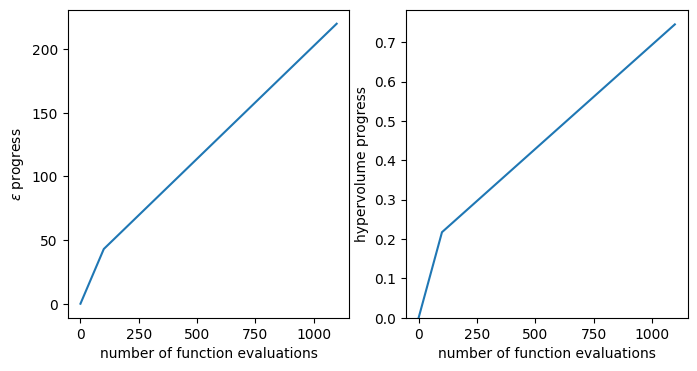

<Figure size 640x480 with 0 Axes>

In [27]:
# Plot convergence metrics
if nfe <= hv_max_nfe:
    # Plot both
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
    ax1.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
    ax1.set_ylabel('$\epsilon$ progress')
    ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
    ax2.set_ylim(ymin=0)
    ax2.set_ylabel('hypervolume progress')
    ax1.set_xlabel('number of function evaluations')
    ax2.set_xlabel('number of function evaluations')
    plt.show()
    if save_figures:
        plt.savefig(figures_path + f"/mordm_convergence_{nfe}.png", dpi=300)
else:
    # Plot only epsilon
    fig, ax = plt.subplots()
    ax.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
    ax.set_ylabel('$\epsilon$ progress')
    ax.set_xlabel('number of function evaluations')
    plt.show()
    if save_figures:
        plt.savefig(figures_path + f"/mordm_convergence_{nfe}.png", dpi=300)

### Constraints and solutions

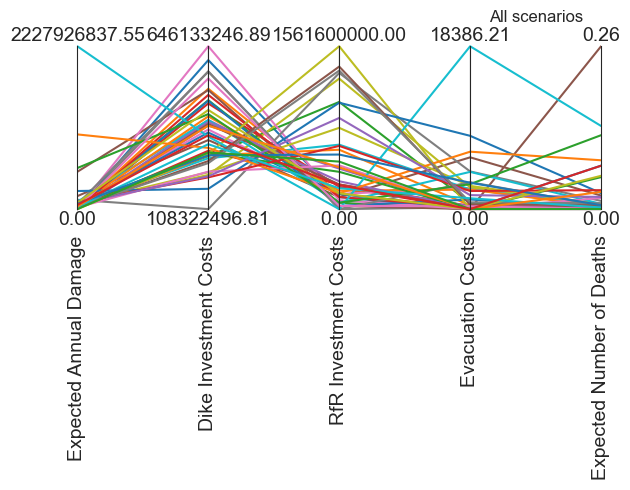

In [28]:
# Plot initial pool of solutions
outcome_data = optimization_result.loc[:, [o.name for o in dike_model.outcomes]]
outcome_limits = parcoords.get_limits(outcome_data)

paraxes = parcoords.ParallelAxes(outcome_limits)
paraxes.plot(outcome_data)
plt.title("All scenarios")
if save_figures:
    plt.savefig(figures_path + f"/parcoords_outcomes_{nfe}.png", dpi=300)
plt.show()

These found solutions will now be constrained to the most for the Delta Commission. For a solution to be allowable, the following criteria must be met:

* Expected number of deaths should not exceed **0.001**.
* **Adaptability**: follow real-life common sense in the long run. Concretely, **not executing RfR in a location where dikes have been previously heightened**, thus undoing the initial investment. The other way around is allowed.

In [29]:
# Constrain solutions by # of deaths
optimization_result_constrained = optimization_result[optimization_result['Expected Number of Deaths'] < 0.001]

In [30]:
# Constrain solutions by excluding dike heightening -> RfR scenarios
def has_rfr_after_dh(series):
    for area in range(5):
        first_rfr_timestep = -1
        for timestep in range(3):
            if series[f"{area}_RfR {timestep}"] > 0:
                first_rfr_timestep = timestep
                break
        last_dike_timestep = 3
        for timestep in range(3):
            if series[f"A.{area + 1}_DikeIncrease {timestep}"] > 0:
                last_dike_timestep = timestep
        if first_rfr_timestep > last_dike_timestep:
            return True
    return False

optimization_result_constrained = optimization_result_constrained[optimization_result_constrained.apply(has_rfr_after_dh, axis="columns") == False]

In [31]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
## Quan: do we need this?
optimization_policies = optimization_result_constrained.drop([o.name for o in dike_model.outcomes], axis=1)
optimization_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,0,0,0,1,0,0,0,...,0,4,2,9,9,1,3,7,4,6
3,0,0,0,0,0,0,1,1,1,0,...,1,2,1,2,5,2,1,7,4,6
4,1,0,0,0,0,0,1,1,0,1,...,0,2,0,0,5,8,4,3,2,3
11,1,1,0,0,1,0,0,1,1,0,...,0,4,0,6,2,0,6,3,3,0
16,0,0,1,0,0,0,0,0,0,0,...,4,7,2,7,4,4,7,7,0,5
23,0,0,1,0,0,0,1,0,0,0,...,3,5,2,6,4,4,7,4,4,3
24,0,1,0,0,0,0,1,1,0,1,...,0,7,2,1,6,0,4,5,3,0
28,0,1,0,0,1,1,1,0,0,0,...,0,5,0,5,5,4,1,3,0,0
36,0,0,0,0,0,0,0,0,1,0,...,2,4,2,8,6,3,5,6,4,1
42,0,0,0,0,0,0,1,1,1,1,...,0,1,1,0,5,1,5,5,2,6


**TO-DO**: We should say something about the trade-offs that we found on the small set of solutions. For instance, sacrificing costs for lower deaths or costs for RfR as a measure of adaptability...
I think here would be very interesting to say something about the model and the constraints it was of the evaluation of RfR. Only one type (although there are many), and checking the water level only in winter (which is a good thing for the transport company to have RfR because when there are droughts they cannot pass anyways)

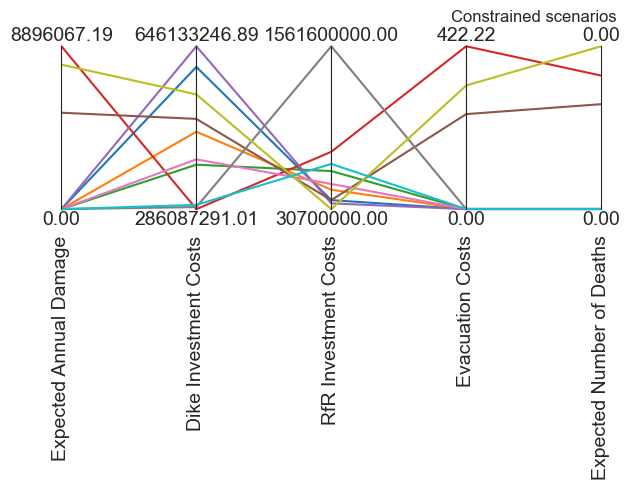

AttributeError: 'NoneType' object has no attribute 'figure'

In [32]:
# Plot the constrained pool of solutions
outcome_data_constrained = optimization_result_constrained.loc[:, [o.name for o in dike_model.outcomes]]
outcome_limits_constrained = parcoords.get_limits(outcome_data_constrained)

paraxes = parcoords.ParallelAxes(outcome_limits_constrained)
paraxes.plot(outcome_data_constrained)
plt.title("Constrained scenarios")
if save_figures:
    plt.savefig(figures_path + f"/parcoords_outcomes_{nfe}_constrained.png", dpi=300)
plt.show()

### Uncertainty

Re-evaluate candidate solutions under uncertainty. Performing experiments with 1000 scenarios for each of the policy options

In [ ]:
# Build list of policies
policies_to_evaluate = []

for i, policy in optimization_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000 # the amount of scenarios for each policy option
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

experiments

In [ ]:
outcomes

### Scenario discovery using PRIM

In [ ]:
# Clean up data = policy parameters, only leaving outcomes etc.
columns_to_drop = ['A.1_DikeIncrease 0','A.1_DikeIncrease 1','A.1_DikeIncrease 2','A.2_DikeIncrease 0','A.2_DikeIncrease 1','A.2_DikeIncrease 2','A.3_DikeIncrease 0','A.3_DikeIncrease 1','A.3_DikeIncrease 2','A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2','A.5_DikeIncrease 0','A.5_DikeIncrease 1','A.5_DikeIncrease 2', 'policy']
columns_to_drop += ['0_RfR 0','0_RfR 1','0_RfR 2','1_RfR 0','1_RfR 1','1_RfR 2','2_RfR 0','2_RfR 1','2_RfR 2','3_RfR 0','3_RfR 1','3_RfR 2','4_RfR 0','4_RfR 1','4_RfR 2','EWS_DaysToThreat']

cleaned_experiments = experiments.copy()
cleaned_experiments.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
# Apply PRIM
x = cleaned_experiments
y = (outcomes['Expected Number of Deaths'] <= 0.001) # the outcome constraint to evaluate using PRIM
prim_alg = prim.Prim(x,y, threshold = 0.5, peel_alpha = 0.01)
box = prim_alg.find_box()

In [ ]:
# Plot PRIM tradeoff graph
box.show_tradeoff(annotated=True)
plt.show()

if save_figures:
    box.show_tradeoff(annotated=False)
    plt.savefig(figures_path + f"/prim_tradeoff.png", dpi=300)

**TO-DO**: here we have to talk about the trade-offs between density and coverage.

In [ ]:
# Inspect PRIM results in graph style
box.inspect(style='graph')
if save_figures:
    plt.savefig(figures_path + f"/prim_inspect_graph.png", dpi=300)
plt.show()


**TO-DO**: rewrite these PRIM conclusions a bit

Bmax is not relevant for deaths. High pfail is correlated with higher deaths.
This only cover 16% of the cases of interests with a density of 1. It is not very conclusive, PRIM had issues explaining the problem without restricting a significant number of dimensions (in the case of this image but once we run the final probably that changes)
PRIM will always suffer a bit because the problem is not linear.

#### Dimensional stacking

As PRIM is not suited to this problem, we now use dimensional stacking to see if we can conclude something else.

In [ ]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
# Blank spaces mean that additional runs are needed for the coverage to increase and get conclusive results. However, as will be discussed, we find that this method is not suited to this problem, and thus we do not do that now.
if save_figures:
    plt.savefig(figures_path + f"/dimensional_stacking_pivot.png", dpi=300)
plt.show()

We will choose a point in the lower 25% (around 0.7 density and 0.7 coverage) to inspect.

In [ ]:
point = 36
box.inspect(point)
box.inspect(point, style='graph')
if save_figures:
    plt.savefig(figures_path + f"/dimensional_stacking_inspect_graph_{point}.png", dpi=300)
plt.show()

Again this is not conclusive, except to say that pfail is importaint but not that one on dike ring 3. (**TO-DO**: rewrite sentence)
We will resample another point in the upper 75%.

In [ ]:
try:
    box.resample(point)
except Exception as e:
    print("Resample failed with exception: " + e)
    print("You can try to run this cell again.")

In [ ]:
# Scatter plot to visually understand the PRIM process
i = min(140,len(box.box_lims)) # limit to maximum

box.select(i)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
if save_figures:
    plt.savefig(figures_path + f"/prim_box_scatter.png", dpi=300)
plt.show()


### Sensitivity analysis using extra trees

Extra trees is less computationally intensive than Sobol. We will use the feature score to understand which of the uncertain values have the highest effect on the outcomes of the model.


In [ ]:
# Use the outcome expected number of deaths as prime indicator
outcomes_deaths = outcomes['Expected Number of Deaths']
outcomes_deaths

In [ ]:
# Calculate scores
scores = feature_scoring.get_ex_feature_scores(
    cleaned_experiments,
    outcomes_deaths,
    max_features=0.6,
    mode=scenario_discovery_util.RuleInductionType.REGRESSION
)[0]

scores

In [ ]:
fig, ax = plt.subplots(1)
scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('Feature scores')
if save_figures:
    plt.savefig(figures_path + f"/extratrees_scores.png", dpi=300)
plt.show()

### Robustness

Two robustness metrics will be studied.

#### Signal-to-noise ratio

In [ ]:
# Function defined as in assignment 9.
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
overall_scores = {}

# Loop over policies
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in dike_model.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores

scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
# Plot the pool of scores
score_data = scores
score_limits = parcoords.get_limits(score_data)

paraxes = parcoords.ParallelAxes(score_limits)
paraxes.plot(score_data)
plt.title("Signal-to-noise ratio scores")
if save_figures:
    plt.savefig(figures_path + f"/parcoords_sn.png", dpi=300)
plt.show()


#### Maximum regret

In [ ]:
# Code as in model answer for assignment 9
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name],
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

In [ ]:
# Create heatmap
max_regret_df = pd.DataFrame(max_regret)
sns.heatmap(max_regret_df/max_regret_df.max(), cmap='viridis', annot=True)
if save_figures:
    plt.savefig(figures_path + f"/maxregret_heatmap.png", dpi=300)
plt.show()

In [ ]:
# Helper function to get unique color map values
def get_cmap_color(cmap, value, max):
    cmap = matplotlib.colormaps[cmap]
    return cmap(value/max)

# Plot parcoords
data = max_regret
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=get_cmap_color('viridis', i, data.shape[0] - 1))
paraxes.legend()
if save_figures:
    plt.savefig(figures_path + f"/maxregret_parcoords.png", dpi=300)
plt.show()


In [ ]:
policy_regret = collections.defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
# this generates 2 plots with a shared y and x axis
fig, axes = plt.subplots(
    cols=2,
    figsize=(10,5),
    sharey=True,
    sharex=True
)

# To ensure easy iteration over the axes grid, we turn it
# into a list. Hard-coded because there are four plots.

# Using zip to loop over axes and policy/regret together.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # We need to scale the regret to ensure fair visual
    # comparison. We can do that by dividing by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
if save_figures:
    plt.savefig(figures_path + f"/maxregret_policies.png", dpi=300)
plt.show()

